In [1]:
! git pull
%pylab inline
import seaborn as sns
from scipy.stats import zscore
from pandas import read_csv
from tqdm import tnrange, tqdm_notebook
from time import sleep
from plotly.offline import download_plotlyjs, init_notebook_mode, iplot,plot
init_notebook_mode()
import CCD_packages
reload(CCD_packages)

Already up-to-date.
Populating the interactive namespace from numpy and matplotlib


/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning:

This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.



<module 'CCD_packages' from 'CCD_packages.pyc'>

In [14]:
import nilearn.datasets
from nilearn import input_data
print('Datasets shipped with nilearn are stored in: %r' % nilearn.datasets.get_data_dirs())
atlas=nilearn.datasets.fetch_atlas_msdl()

Datasets shipped with nilearn are stored in: ['/home/jmuraskin/nilearn_data']


In [8]:
GroupDF,motionInfo=CCD_packages.getCCDSubjectData()
TrainDF=CCD_packages.getCCDSubjectTrainData()
goodsubj,badsubj = CCD_packages.getSubjectList(GroupDF=GroupDF,motionThresh=1)

No DR .txt file found or error for subject : CCD061
No DR .txt file found or error for subject : CCD061
Subject CCD061 has no file


In [25]:


# masker = nilearn.input_data.NiftiMapsMasker(
#     atlas.maps, resampling_target="maps", detrend=False,
#     t_r=2.0, standardize=True,
#     memory='nilearn_cache', memory_level=1)
numberOfICs=10
columnNames=[]
for rsnNumber in range(numberOfICs):
        columnNames.append('RSN%d' % rsnNumber)

subjects = []
# sites = []
fb = []
subjGroup=[]
for subjNum,subj in enumerate(goodsubj): 
#     print 'Running Subject %s' % subj
    for run in ['FEEDBACK','NOFEEDBACK']:
#         func_file='/home/jmuraskin/Projects/CCD/CPAC-out/pipeline_CCD_v1/%s_data_/functional_mni_other_resolutions_smooth/_scan_feedback_%d/_csf_threshold_0.96/_gm_threshold_0.7/_wm_threshold_0.96/_apply_isoxfm_3.0/_compcor_ncomponents_5_selector_pc10.linear1.wm0.global0.motion1.quadratic1.gm0.compcor1.csf1/_fwhm_6/residual_antswarp_maths.nii.gz' % (subj,run)
#         time_series = masker.fit_transform(func_file)
#         if run == 'TRAIN':
#             subjects.append(np.array(TrainDF[TrainDF.Subject_ID==subj][columnNames]))
#         else:
#             subjects.append(np.array(GroupDF[np.all([GroupDF.Subject_ID==subj,GroupDF.FB==run],axis=0)][columnNames]))
        subjGroup.append(subjNum)
#         fb.append(run)

        
import pickle


favorite_color = pickle.load( open( "Train_MSDL_global0.p", "rb" ) )
Train=favorite_color['subjectTimeSeries']
favorite_color = pickle.load( open( "MSDL_global0_FB_NFB.p", "rb" ) )
subjects=favorite_color['subjectTimeSeries']
fb=favorite_color['fb']

In [26]:
for indx,train in enumerate(Train):
    subjects.append(train)
    fb.append('TRAIN')
    subjGroup.append(indx)


In [23]:
np.shape(individual_connectivity_matrices['tangent'])

(141, 39, 39)

In [119]:
import nilearn.connectome
kinds = ['tangent', 'partial correlation', 'correlation','precision']
individual_connectivity_matrices = {}
mean_connectivity_matrix = {}
for kind in kinds:
    conn_measure = nilearn.connectome.ConnectivityMeasure(kind=kind)
    individual_connectivity_matrices[kind] = conn_measure.fit_transform(
        subjects)
    # Compute the mean connectivity
    if kind == 'tangent':
        mean_connectivity_matrix[kind] = conn_measure.mean_
    else:
        mean_connectivity_matrix[kind] = \
            individual_connectivity_matrices[kind].mean(axis=0)

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison



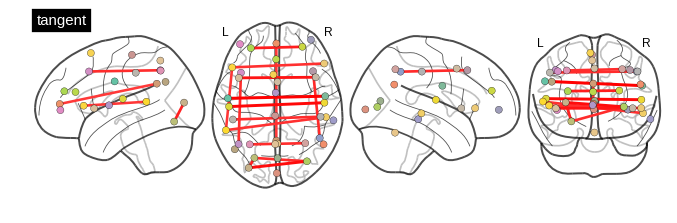

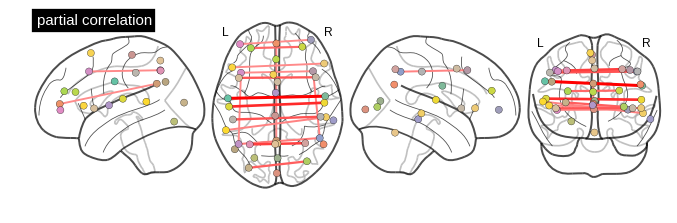

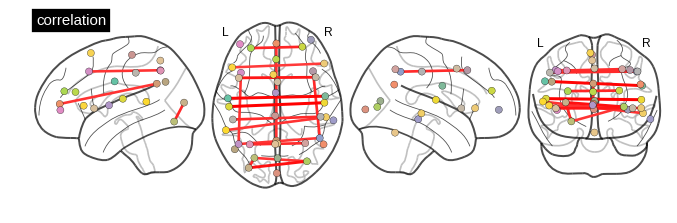

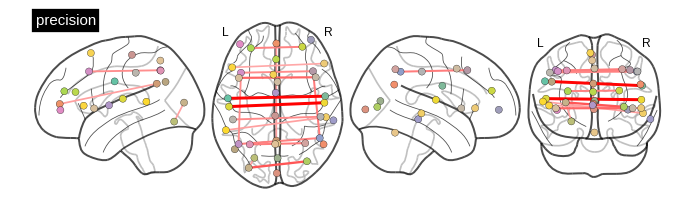

In [16]:
import nilearn.plotting
labels = atlas.labels
region_coords = atlas.region_coords
for kind in kinds:
    nilearn.plotting.plot_connectome(-mean_connectivity_matrix[kind] if kind=='precision' else mean_connectivity_matrix[kind],
                                     region_coords, edge_threshold='98%',
                                     title=kind, display_mode='lzry')

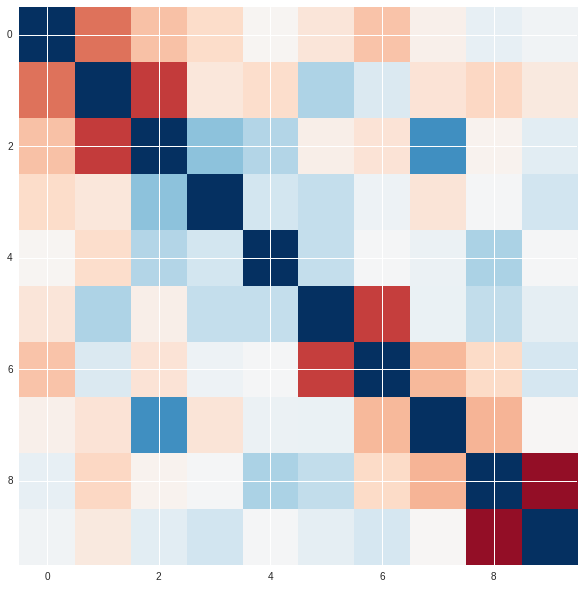

In [6]:
plt.figure(figsize=(10, 10))
# Mask the main diagonal for visualization:
CCD_packages.np.fill_diagonal(-mean_connectivity_matrix['precision'],0)

plt.imshow(-mean_connectivity_matrix['precision'], interpolation="nearest", cmap="RdBu_r",
           vmax=0.8, vmin=-0.8)

In [28]:
indices=CCD_packages.np.triu_indices(len(region_coords),1)
performance=read_csv('/home/jmuraskin/Projects/CCD/CCD-scripts/analysis/CCD_performance.csv',names=['Subject_ID','FB','scanorder','R'])
motionTest=read_csv('/home/jmuraskin/Projects/CCD/CCD-scripts/analysis/CCD_meanFD.csv')
fbNames=['FEEDBACK','NOFEEDBACK']

In [127]:
from sklearn.linear_model import SGDRegressor,ARDRegression
from sklearn.model_selection import GridSearchCV,LeaveOneGroupOut,LeaveOneOut,KFold
from sklearn.pipeline import Pipeline
from sklearn import feature_selection
from sklearn.metrics import r2_score
import statsmodels.formula.api as sm
from nilearn.signal import clean
import random
 
    
#choose which classification

# 1 FB versus NFB
# 2 FB versus Train
# 3 NFB versus Train
fb=np.array(fb)
subjGroup=np.array(subjGroup)
classNames=['FBvPerformance','NFBvsPerformance','TRAINvsFBPerformance','TRAINvsNFBPerformacne']
kinds = ['precision']
nperms=0
scale=1
elastic=0
coefs_class={}
y_preds_class={}
edge_maps_class={}
permR2_class={}
mean_scores_class={}
remove_motion_from_input=1
remove_motion_from_y=1


def shuffleOrders(y):
    y_new = y.copy()
    
    random.shuffle(y_new)
        
    return y_new


def run_LOO_regression(X,y):
    cv=KFold(2)
    loo = LeaveOneOut() # cross-validation generator for model selection
    ridge = ARDRegression()

    # Anova univariate feature selection followed by BayesianRidge
    f_regression = feature_selection.f_regression
    anova = feature_selection.SelectPercentile(f_regression)
    y_pred=np.zeros((len(y),))
    params=[]
    for train_index, test_index in loo.split(X):
        ("TRAIN:", train_index, "TEST:", test_index)
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        if not elastic:
            clf = Pipeline([('anova', anova), ('ridge', ridge)])
#         Select the optimal percentage of features with grid search
            clf = GridSearchCV(clf, {'anova__percentile': [1,5,10,15,20]}, cv=cv,scoring='neg_mean_squared_error')

        else:
            clf = SGDRegressor(penalty='l1', alpha=0.0001, l1_ratio=1,fit_intercept=False)
        clf.fit(X_train, y_train)  # set the best parameters
    #     params.append(clf.coef_)
        y_pred[test_index]=clf.predict(X_test)
        if not elastic:
            coef_ = clf.best_estimator_.steps[-1][1].coef_
            coef_ = clf.best_estimator_.steps[0][1].inverse_transform(coef_.reshape(1, -1))
        else:
            coef_ = clf.coef_
        params.append(coef_)
    
    return y_pred, params


                


for classification in tnrange(len(classNames),desc='Classification Type'):
    if classification==0:
        y = zscore(CCD_packages.np.arctanh(performance[performance.FB=='FEEDBACK'][performance.Subject_ID.isin(goodsubj)]['R']).values)
        if remove_motion_from_y:
            y = clean(y,confounds=np.array(motionTest[motionTest.FB=='FEEDBACK'][motionTest.Subject_ID.isin(goodsubj)]['meanFD']),detrend=False,standardize=False)
        fbIndx=np.nonzero(fb=='Feedback')
    elif classification==1:
        y = zscore(CCD_packages.np.arctanh(performance[performance.FB=='NOFEEDBACK'][performance.Subject_ID.isin(goodsubj)]['R']).values)
        if remove_motion_from_y:
            y = clean(y,confounds=np.array(motionTest[motionTest.FB=='NOFEEDBACK'][motionTest.Subject_ID.isin(goodsubj)]['meanFD']),detrend=False,standardize=False)
        fbIndx=np.nonzero(fb=='NoFeedback')
    elif classification==2:
        y = zscore(CCD_packages.np.arctanh(performance[performance.FB=='FEEDBACK'][performance.Subject_ID.isin(goodsubj)]['R']).values)
        if remove_motion_from_input:
            y = clean(y,confounds=np.array(motionTest[motionTest.FB=='FEEDBACK'][motionTest.Subject_ID.isin(goodsubj)]['meanFD']),detrend=False,standardize=False)
        fbIndx=np.nonzero(fb=='TRAIN')
        
    elif classification==3:
        y = zscore(CCD_packages.np.arctanh(performance[performance.FB=='NOFEEDBACK'][performance.Subject_ID.isin(goodsubj)]['R']).values)
        if remove_motion_from_y:
            y = clean(y,confounds=np.array(motionTest[motionTest.FB=='NOFEEDBACK'][motionTest.Subject_ID.isin(goodsubj)]['meanFD']),detrend=False,standardize=False)
        fbIndx=np.nonzero(fb=='TRAIN')


    fbIndx=fbIndx[0]
    
    mean_scores = {}



    coefs={}
    y_preds={}
    edge_maps={}
    permR2s={}

    for kindNum in tnrange(len(kinds),desc='Connectivity Type'):
        kind=kinds[kindNum]
        print('Classification using %s for %s accuracy:' % (kind,classNames[classification]))
        # Transform the connectivity matrices to 1D arrays
        coonectivity_coefs = nilearn.connectome.sym_to_vec(
            -individual_connectivity_matrices[kind] if kind=='precision' else individual_connectivity_matrices[kind],discard_diagonal=True)
        if scale:
            if remove_motion_from_input:
                X_new=zscore(coonectivity_coefs[fbIndx,:],axis=0)
                if classification==0:
                    X_new = clean(X_new,confounds=np.array(motionTest[motionTest.FB=='FEEDBACK'][motionTest.Subject_ID.isin(goodsubj)]['meanFD']),detrend=False,standardize=False)
                elif classification==1:
                    X_new = clean(X_new,confounds=np.array(motionTest[motionTest.FB=='NOFEEDBACK'][motionTest.Subject_ID.isin(goodsubj)]['meanFD']),detrend=False,standardize=False)
                else:
                    X_new = clean(X_new,confounds=np.array(motionTest[motionTest.FB=='NOFEEDBACK'][motionTest.Subject_ID.isin(goodsubj)]['train_meanFD']),detrend=False,standardize=False)
            else:
                X_new=zscore(coonectivity_coefs[fbIndx,:],axis=0)
        else:
            X_new=coonectivity_coefs.copy()   
        
        permR2=[]
        if nperms>0:
            for n in tnrange(nperms, desc='Permutations'):
                y_new=shuffleOrders(y)
                y_pred,_=run_LOO_regression(X_new,y_new)
                permR2.append(r2_score(y_new,y_pred))
                sleep(0.01)

        y_pred,coefs_=run_LOO_regression(X_new,y)

        print('%20s score: %1.2f' % (kind, r2_score(y,y_pred)))
        mean_scores[kind]=r2_score(y,y_pred)
        coefs[kind]=coefs_
        y_preds[kind]=y_pred
        permR2s[kind]=permR2
        kind=kinds[0]
        edge_map=CCD_packages.np.zeros((len(region_coords),len(region_coords)))
        edge_map[indices]=np.mean(coefs[kind],axis=0)
        edge_maps[kind]=edge_map
    coefs_class[classNames[classification]]=coefs
    y_preds_class[classNames[classification]]=y_preds
    edge_maps_class[classNames[classification]]=edge_maps
    permR2_class[classNames[classification]]=permR2s
    mean_scores_class[classNames[classification]]=mean_scores

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/ipykernel/__main__.py:79: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/ipykernel/__main__.py:81: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/ipykernel/__main__.py:122: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



Classification using precision for FBvPerformance accuracy:
           precision score: 0.16
Classification using precision for NFBvsPerformance accuracy:


/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/ipykernel/__main__.py:84: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/ipykernel/__main__.py:86: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/ipykernel/__main__.py:124: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



           precision score: -0.19
Classification using precision for TRAINvsFBPerformance accuracy:


/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/ipykernel/__main__.py:89: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/ipykernel/__main__.py:91: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/ipykernel/__main__.py:126: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



           precision score: -0.28
Classification using precision for TRAINvsNFBPerformacne accuracy:


/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/ipykernel/__main__.py:95: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/ipykernel/__main__.py:97: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



           precision score: -0.91



In [118]:
coonectivity_coefs



array([ 0.55000212, -0.11565096,  0.2800761 , -0.08579605,  0.26674605,
        0.02838455])

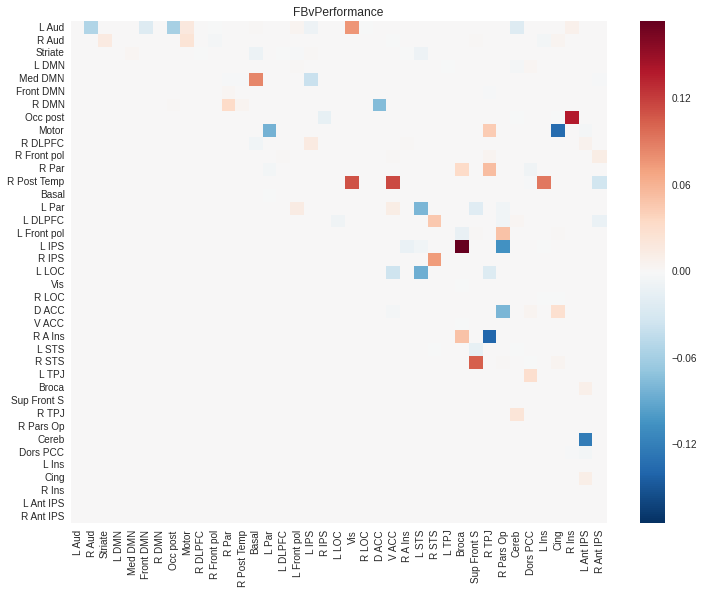

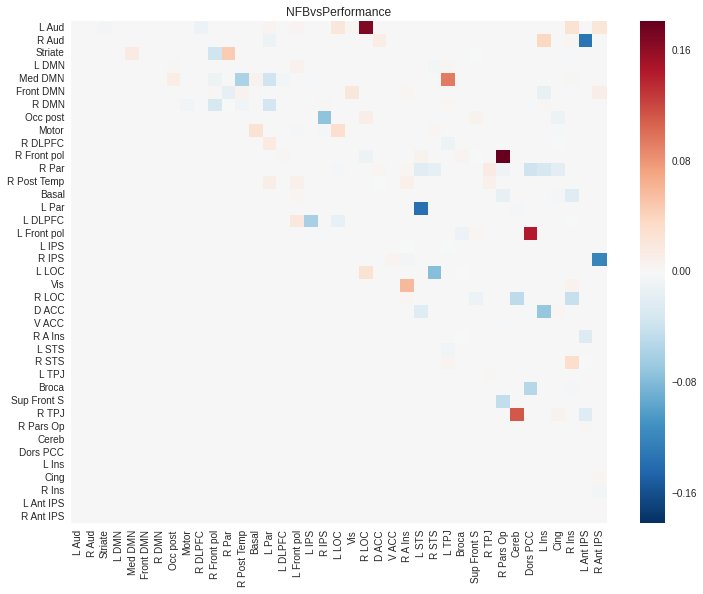

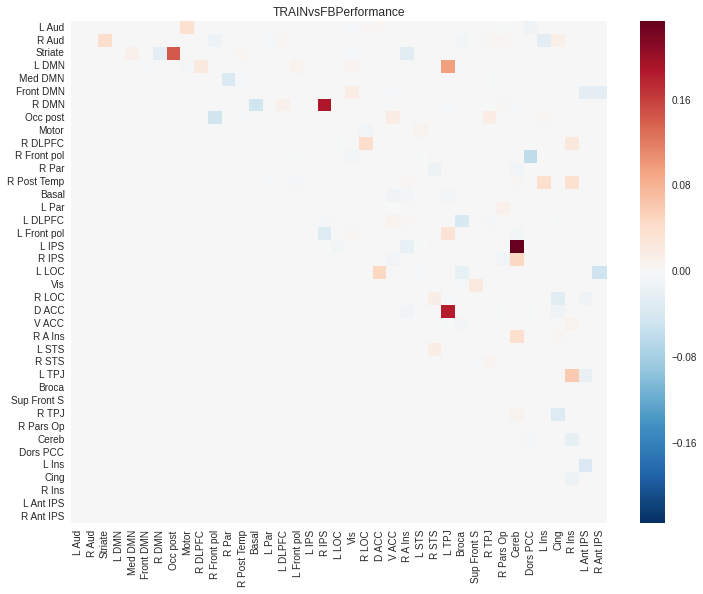

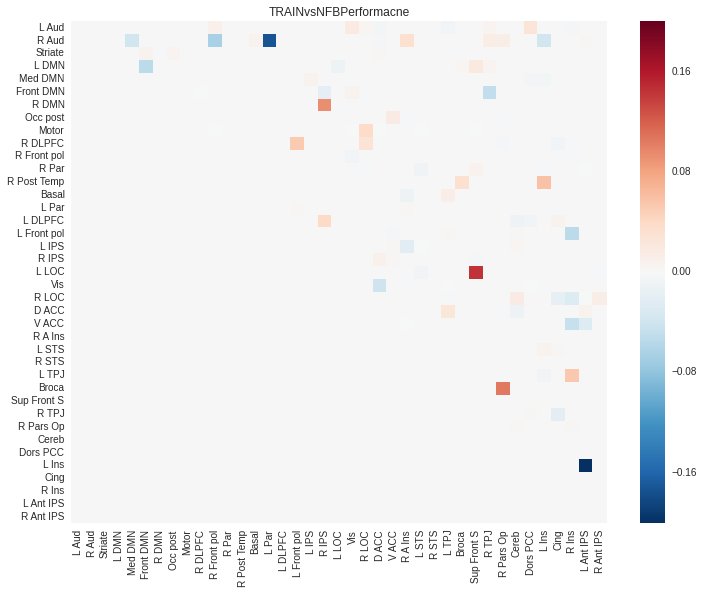

In [128]:
kind='precision'
for n in classNames:    
    plt.subplots(figsize=(12,9))
    sns.heatmap(edge_maps_class[n][kind],xticklabels=labels,yticklabels=labels)
    plt.title(n)

In [63]:
for n in classNames:    
    fig=CCD_packages.heatmap2Chord(edge_maps_class[n][kind],title=n,savefig=False,scale=[-1,1])
    iplot(fig)

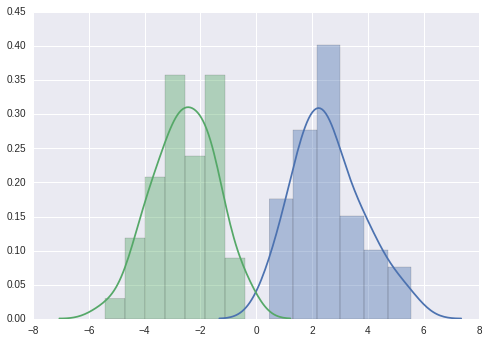

In [32]:
import seaborn as sns


sns.distplot(y_preds[kind][y==1])
sns.distplot(y_preds[kind][y==0])



/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/ipykernel/__main__.py:1: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/ipykernel/__main__.py:1: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



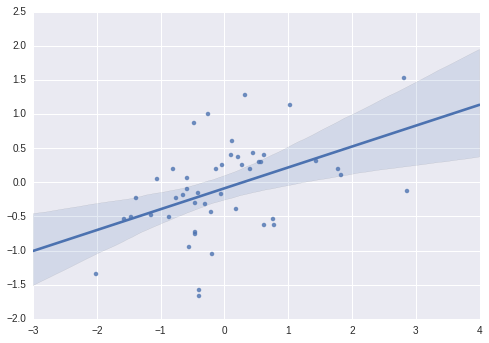

In [126]:
y = zscore(CCD_packages.np.arctanh(performance[performance.FB=='FEEDBACK'][performance.Subject_ID.isin(goodsubj)]['R']).values)
sns.regplot(y,y_preds_class['FBvPerformance']['precision'])

In [80]:
for n in classNames:    
    print ('%s P-Value : %0.4f' % (n,np.float(sum(permR2_class[n][kind]>mean_scores_class[n][kind]))/nperms))

FBvPerformance P-Value : 0.6890
NFBvsPerformance P-Value : 0.0040
TRAINvsFBPerformance P-Value : 0.0020
TRAINvsNFBPerformacne P-Value : 0.0240


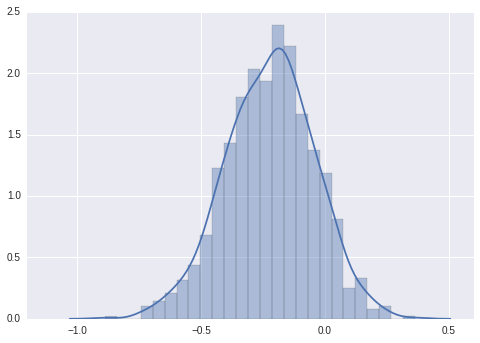

In [71]:
sns.distplot(permR2_class['FBvPerformance'][kind])

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/ipykernel/__main__.py:1: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/ipykernel/__main__.py:2: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



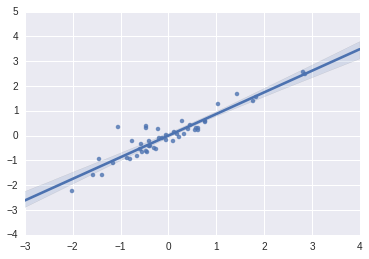

In [94]:
y = zscore(CCD_packages.np.arctanh(performance[performance.FB=='FEEDBACK'][performance.Subject_ID.isin(goodsubj)]['R']).values)
result = sm.OLS(y,zscore(motionTest[motionTest.FB=='FEEDBACK'][motionTest.Subject_ID.isin(goodsubj)]['meanFD']) ).fit()
sns.regplot(y,result.resid)

In [190]:
from nilearn.signal import clean

y = zscore(CCD_packages.np.arctanh(performance[performance.FB=='FEEDBACK'][performance.Subject_ID.isin(goodsubj)]['R']).values)
if remove_motion_from_y:
    y_new = clean(y,confounds=np.array(motionTest[motionTest.FB=='FEEDBACK'][motionTest.Subject_ID.isin(goodsubj)]['meanFD']),detrend=False,standardize=False)


/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/ipykernel/__main__.py:3: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/ipykernel/__main__.py:5: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



In [98]:
from sklearn.linear_model import SGDRegressor,ARDRegression
from sklearn.model_selection import GridSearchCV,LeaveOneGroupOut,LeaveOneOut,KFold
from sklearn.pipeline import Pipeline
from sklearn import feature_selection
from sklearn.metrics import r2_score
import statsmodels.formula.api as sm
from nilearn.signal import clean
import random
 
    
#choose which classification

# 1 FB versus NFB
# 2 FB versus Train
# 3 NFB versus Train
fb=np.array(fb)
subjGroup=np.array(subjGroup)
classNames=['FBvPerformance','NFBvsPerformance','TRAINvsFBPerformance','TRAINvsNFBPerformacne']
kinds = ['precision','tangent','correlation','partial correlation']
nperms=0
scale=1
elastic=1
tvals_class={}
pvals_class={}
edge_maps_class={}
pval_maps_class={}
remove_motion_from_input=0
remove_motion_from_y=0


def run_RLM_regression(X,y,motion):
    tval=[]
    pval=[]
    for n in range(X.shape[1]):
        results=sm.OLS(y,np.column_stack((X[:,n],motion))).fit()
        tval.append(results.tvalues[0])
        pval.append(results.pvalues[0])
                       
    return tval,pval
              


for classification in tnrange(len(classNames),desc='Classification Type'):
    if classification==0:
        y = zscore(CCD_packages.np.arctanh(performance[performance.FB=='FEEDBACK'][performance.Subject_ID.isin(goodsubj)]['R']).values)
        fbIndx=np.nonzero(fb=='Feedback')
    elif classification==1:
        y = zscore(CCD_packages.np.arctanh(performance[performance.FB=='NOFEEDBACK'][performance.Subject_ID.isin(goodsubj)]['R']).values)
        fbIndx=np.nonzero(fb=='NoFeedback')
    elif classification==2:
        y = zscore(CCD_packages.np.arctanh(performance[performance.FB=='FEEDBACK'][performance.Subject_ID.isin(goodsubj)]['R']).values)
        fbIndx=np.nonzero(fb=='TRAIN')
        
    elif classification==3:
        y = zscore(CCD_packages.np.arctanh(performance[performance.FB=='NOFEEDBACK'][performance.Subject_ID.isin(goodsubj)]['R']).values)
        fbIndx=np.nonzero(fb=='TRAIN')


    fbIndx=fbIndx[0]
    
    mean_scores = {}



    tvals={}
    pvals={}
    edge_maps={}
    pval_maps={}

    for kindNum in tnrange(len(kinds),desc='Connectivity Type'):
        kind=kinds[kindNum]
        print('Classification using %s for %s accuracy:' % (kind,classNames[classification]))
        # Transform the connectivity matrices to 1D arrays
        coonectivity_coefs = nilearn.connectome.sym_to_vec(
            -individual_connectivity_matrices[kind] if kind=='precision' else individual_connectivity_matrices[kind],discard_diagonal=True)
        if scale:
            X_new=zscore(coonectivity_coefs[fbIndx,:],axis=0)
                
        else:
            X_new=coonectivity_coefs.copy()   
        
        if classification==0:
            motion = zscore(np.array(motionTest[motionTest.FB=='FEEDBACK'][motionTest.Subject_ID.isin(goodsubj)]['meanFD']))
        elif classification==1:
            motion = zscore(np.array(motionTest[motionTest.FB=='NOFEEDBACK'][motionTest.Subject_ID.isin(goodsubj)]['meanFD']))
        else:
            motion = zscore(np.array(motionTest[motionTest.FB=='FEEDBACK'][motionTest.Subject_ID.isin(goodsubj)]['train_meanFD']))

                       
        tval,pval = run_RLM_regression(X_new,y,motion)

        
        tvals[kind]=tval
        pvals[kind]=pval
        edge_map=CCD_packages.np.zeros((len(region_coords),len(region_coords)))
        edge_map[indices]=tvals[kind]
        edge_maps[kind]=edge_map.copy()
        edge_map[indices]=pvals[kind]
        pval_maps[kind]=edge_map
    tvals_class[classNames[classification]]=tvals
    pvals_class[classNames[classification]]=pvals
    edge_maps_class[classNames[classification]]=edge_maps
    pval_maps_class[classNames[classification]]=pval_maps


/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/ipykernel/__main__.py:45: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/ipykernel/__main__.py:83: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



Classification using precision for FBvPerformance accuracy:
Classification using tangent for FBvPerformance accuracy:
Classification using correlation for FBvPerformance accuracy:
Classification using partial correlation for FBvPerformance accuracy:
Classification using precision for NFBvsPerformance accuracy:


/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/ipykernel/__main__.py:48: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/ipykernel/__main__.py:85: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



Classification using tangent for NFBvsPerformance accuracy:
Classification using correlation for NFBvsPerformance accuracy:
Classification using partial correlation for NFBvsPerformance accuracy:
Classification using precision for TRAINvsFBPerformance accuracy:


/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/ipykernel/__main__.py:51: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/ipykernel/__main__.py:87: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



Classification using tangent for TRAINvsFBPerformance accuracy:
Classification using correlation for TRAINvsFBPerformance accuracy:
Classification using partial correlation for TRAINvsFBPerformance accuracy:
Classification using precision for TRAINvsNFBPerformacne accuracy:


/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/ipykernel/__main__.py:55: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



Classification using tangent for TRAINvsNFBPerformacne accuracy:
Classification using correlation for TRAINvsNFBPerformacne accuracy:
Classification using partial correlation for TRAINvsNFBPerformacne accuracy:



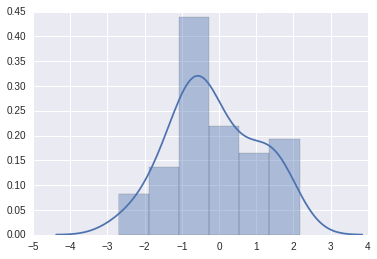

In [241]:
sns.distplot(tval)

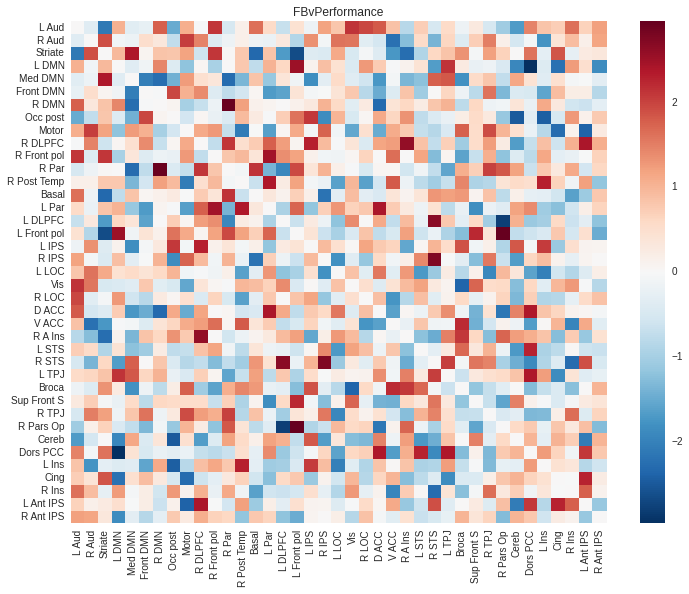

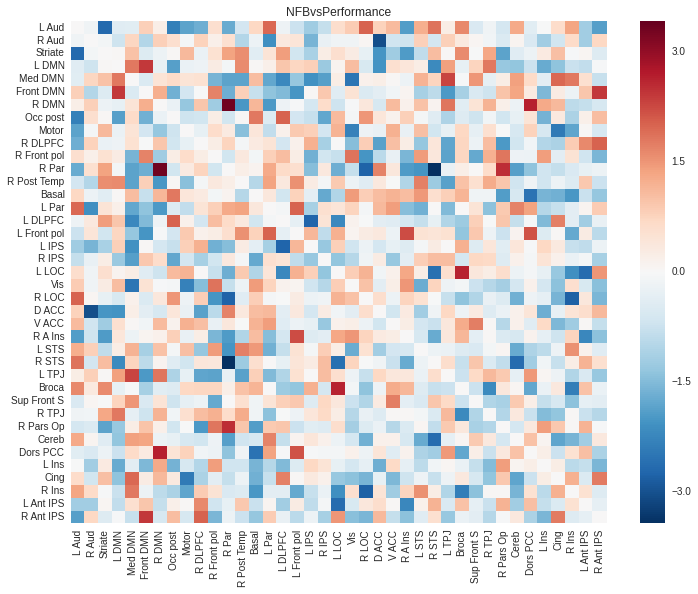

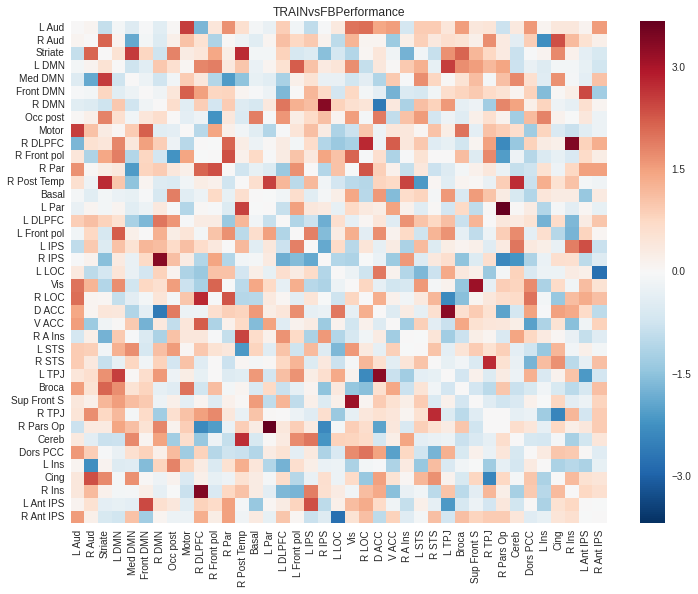

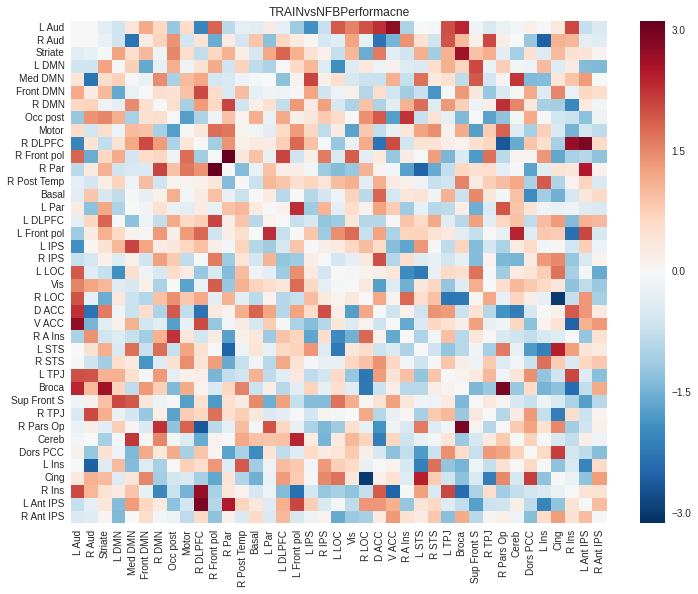

In [84]:
kind='tangent'
for n in classNames:    
    plt.subplots(figsize=(12,9))
    sns.heatmap((edge_maps_class[n][kind]+edge_maps_class[n][kind].T),xticklabels=labels,yticklabels=labels)
    plt.title(n)

In [70]:
DMNL0=indices[0][:]==6
DMNL1=indices[1][:]==6

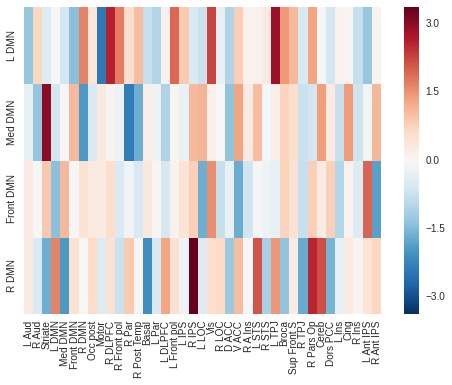

In [111]:
tmpMat=(edge_maps_class['TRAINvsFBPerformance']['precision']+edge_maps_class['TRAINvsFBPerformance']['precision'].T)
pvalMat=(pval_maps_class['TRAINvsFBPerformance']['precision']+pval_maps_class['TRAINvsFBPerformance']['precision'].T)
sns.heatmap(tmpMat[range(3,7),:],yticklabels=labels[3:7],xticklabels=labels)

In [116]:
from mne.stats import fdr_correction

reject,pfdr=fdr_correction(pvalMat[pvalMat!=0])
print sum(reject)
np.min(pvalMat[pvalMat!=0])

0


0.0015215373306522121

In [72]:
coonectivity_coefs = nilearn.connectome.sym_to_vec(
            -individual_connectivity_matrices[kind][range(3,7),range(3,7)] if kind=='precision' else individual_connectivity_matrices[kind][range(3,7),range(3,7)],discard_diagonal=True)

In [78]:
np.shape(individual_connectivity_matrices[kind][:,range(3,7),:])

(141, 4, 39)

In [124]:
np.array(motionTest[motionTest.FB=='FEEDBACK'][motionTest.Subject_ID.isin(goodsubj)]['meanFD'])

/home/jmuraskin/miniconda/envs/cpac040/lib/python2.7/site-packages/ipykernel/__main__.py:1: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



array([ 0.13302182,  0.07532585,  0.28380837,  0.0781343 ,  0.13801745,
        0.0875055 ,  0.07173198,  0.14245844,  0.17978618,  0.09865319,
        0.11348691,  0.16658661,  0.1160961 ,  0.15990699,  0.10549408,
        0.11812409,  0.1164823 ,  0.29030446,  0.16868599,  0.12623936,
        0.37526302,  0.11967766,  0.14384289,  0.16298238,  0.09656483,
        0.24475508,  0.22126764,  0.30528751,  0.22466388,  0.13606868,
        0.1796987 ,  0.17788083,  0.51368065,  0.12355325,  0.19022079,
        0.16283814,  0.36289191,  0.10314997,  0.1069917 ,  0.18809709,
        0.12500777,  0.17767245,  0.23208274,  0.09493521,  0.10962392,
        0.13518184,  0.23008319])